In [161]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

options(warn=-1)  ### SUPPRESS WARNING MSG

## Introduction

The study involves two separate sessions: motor learning and working memory tasks (counterbalanced) tested on different days.

(1) In the motor learning task, subjects randomly explored the space along an invisible arc in the left workspace. On the 16th trial, unbeknownst to them, we set the target by providing a boom. Subsequently, they have to keep repeating the movements to obtain more booms.

(2) In the working memory task, subjects arm were displaced in 3 different directions. They had to guess whether the test direction presented after was one of the previously given directions. Only 2 lags were tested. WM score was computed as Hit - FA. There were 3 blocks during PRE (before) and POST (after) TMS respectively.

<b>Hypothesis</b>= TMS on 46v would result in a decrease in WM scores and, consequently, motor learning.

In [368]:
######### This file directly reads textfile from the experiment ############
rm(list = ls())
options(width=200)

require('ggplot2')
require('plyr')
require('Rmisc')
require("reshape")

getwd()
dirpath <- "/home/ae2017/Documents/R/TMS/"   # home directory in linux is shown as ~
setwd(dirpath)

## Easier to select which test version to use. This also determines filename to save.
myTest_version_string = "tms_param"   
#source("test_param.R")
source(paste(myTest_version_string,".R",sep=""))


allsubjects <- NULL
anchors <- 1: nANCHOR

################### Open textfile containing raw data!!!
allsubjects <- read.csv("all_wm.csv", header=TRUE)
#allsubjects <- subset(allsubjects, !subj.id %in% c("rac","tom","liz","tub"))
allsubjects <- subset(allsubjects, !subj.id %in% c("liz","nat"))


################### What if we remove some blocks in PRE (block 1-3) and POST (block 4-6)
allsubjects <- subset(allsubjects, block %in% c(1,2,3,4,5,6))


## Make a column that represents for a given trial, whether the probe was one of the anchors or not
get.lag <- function(row) {
  ## Takes as input a row, and outputs a number that tells us which anchor was equal to the probe,
  ## or, if the probe was not among the anchors, then it returns NA.
  #index <- which(row$probe == row[,c('anchor1','anchor2','anchor3','anchor4','anchor5','anchor6')])
  index <- which(row$probe == row[,c(sprintf("anchor%i",anchors))])
  if (length(index)==0) { return (NA) } else { return (index-nANCHOR-1) }
  ## Ananda update: chronological order uses negative value, lag -6 means 6 directions ago from probe.
}

allsubjects$lag <- NA
## Go and check each row of our allsubjects data.
for (i in 1:nrow(allsubjects)) {
  allsubjects[i,]$lag <- get.lag(allsubjects[i,]);   ## Call the 'get.lag' function
}



# Creating 2 additional columns for correct answer and subject score!
allsubjects$lag <- as.factor(allsubjects$lag)
allsubjects$correct.answer <- ifelse( is.na(allsubjects$lag), 0, 1)
allsubjects$score <- ifelse( allsubjects$answer==allsubjects$correct.answer, 1, 0)


## For each of the anchors, compute the distance to the probe.
## NOTE: we invert the order of the anchors here. So dist1 refers to the distance
## to the probe of the *most recent* anchor (i.e. anchor 6), not the first anchor.
for (i in 1:nANCHOR) {
  allsubjects[,sprintf("dist%i",i)] <- abs(allsubjects$probe - allsubjects[,sprintf("anchor%i",nANCHOR+1-i)])
}

allsubjects$dist.all <- as.factor(paste(allsubjects$dist1,allsubjects$dist2,allsubjects$dist3,sep=","))

subset.df <- subset(allsubjects,score==0)
#summarySE(subset.df, "score", c("lag","dist.all"))

#### Note: What if we remove trials in which the distance between the earliest anchor direction 
#### probe = 10 degrees. Assumption here is that these trials are too difficult for subjects.
#allsubjects<-subset(allsubjects,dist3!=10)



#### Get the number of subjects in each group.....
sprintf("Lets see how many subjects in each group.....")
ddply(allsubjects, "group", summarize, "count"=length(unique(subj.id)))


[1] "/home/ae2017/Documents/R/TMS"

[1] "Lets see how many subjects in each group....."

group,count
sham,12
tms,10


In [369]:
prop.yes <- ddply ( allsubjects, 
                    c("subj.id", "block", "lag", "group"),  # Note the grouping variables
                    function(xx) {
                        if (length(xx$answer)>1 && !is.na(xx$answer)) {
                           prop = sum(xx$answer)/length(xx$answer)
                           n = nrow(xx)
                           if ((sum(xx$answer) == length(xx$answer)) | (sum(xx$answer) == 0)) {
                              corrected = (sum(xx$answer) + 0.5)/(length(xx$answer)+1)
                           } 
                           else { corrected = prop }
                        }
                        else { 
                           prop = NA;  corrected = NA; n = 1 } # revised Feb 2018, for visual task with NA
                        return (c("uncorr" = prop,
                                  "prop.yes"= corrected,    ##### Corrected or uncorrected ??????
                                  "n" = n))
                    })


# NOTE: prop.yes contains both proportion of YES responses in trials when probe = anchor and probe = lures.
# We only want the Hit rate, that is, when probe = anchor. Next, we have to select just the lure trials 
# which we need to extract false alarm to compute hit minus false alarm.
#
no.lag <- subset(prop.yes, is.na(lag))

false.alarms <- data.frame(subj.id     = no.lag$subj.id,
                           block       = no.lag$block,
                           false.alarm = no.lag$prop.yes,    # Here, FA is based on corrected values
                           true.neg    = 1-no.lag$prop.yes)  # Specificity, true negative rate

# Merge two data frames!
hit.fa <- merge(subset(prop.yes,!is.na(lag)), false.alarms)
#hit.fa <- merge(subset(prop.yes,n!=12), false.alarms)


## Now compute WM performance;  (Revised Feb 2018 for visual WM with no data, NA).
## Which one is the best performance measure for WM?
hit.fa$hit.min.fa <- hit.fa$prop.yes- hit.fa$false.alarm                   # (1) Hit-FA rate, corrected
hit.fa$dprime <- qnorm(hit.fa$prop.yes) - qnorm(hit.fa$false.alarm)        # (2) dprime, corrected
hit.fa$beta <- exp(-qnorm(hit.fa$prop.yes)*qnorm(hit.fa$prop.yes)/2 +      # (3) beta, corrected
                    qnorm(hit.fa$false.alarm)*qnorm(hit.fa$false.alarm)/2)



## Working memory 
The effect of cTBS on working memory performance can be quantified by comparing WM scores before and after TMS. Working memory score is estimated as the difference in Hit - FA. Additionally, I want to see average WM scores across test blocks (PRE: block 1-3, POST: block 4-6).

In [370]:
wm.blocks <- ddply(hit.fa, c("subj.id","lag","block","group"), function(xx){
                  return(data.frame( "wm"  = mean(xx$hit.min.fa, na.rm=TRUE),
                                     "hit" = mean(xx$prop.yes, na.rm=TRUE),
                                     "fa"  = mean(xx$false.alarm, na.rm=TRUE) ))
} )

wm.blocks.melt <- melt(wm.blocks, id.vars = c("subj.id","block","group"), 
                      measure.vars = c("wm","hit","fa"))

wm.blocks.melt <- summarySE(wm.blocks.melt, "value", c("subj.id","block","group","variable"), na.rm=TRUE)
#wm.blocks.melt

# Paying more attention to outliers, subjects who didn't behave well.
#wm.blocks.melt <- subset(wm.blocks.melt, group=="sham")

# Let's plot them so we can visualize...
options(repr.plot.width=6, repr.plot.height=5)
#ggplot( wm.blocks.melt, aes(x=block, y=value,
#                            ymax=value+se, 
#                            ymin=value-se,
#                            col=as.factor(subj.id) 
#                           )) + 
#  geom_point() + geom_line() +
#  geom_errorbar(width=0) +
#  facet_grid(variable~group,scales="free_y") + ylab("Mean scores")+
#  theme_bw() 

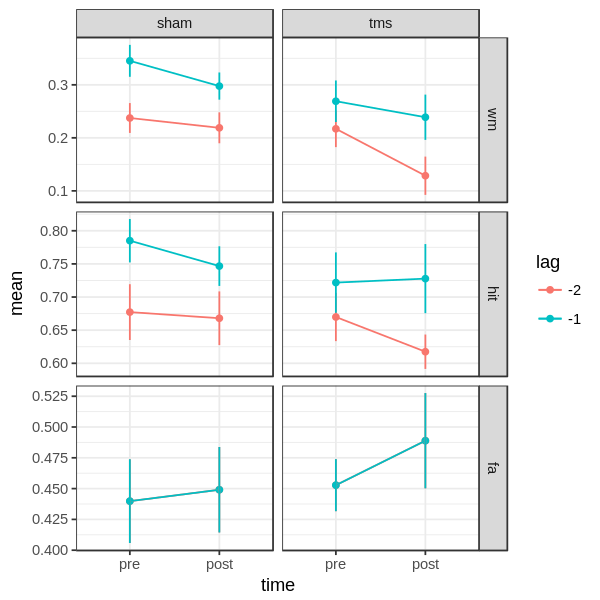

In [371]:
pre.post <- ddply(hit.fa, c("subj.id","lag","group"), function(xx){
                  pre  <- subset(xx, block <=3 )
                  post <- subset(xx, block > 3 )
                  return(data.frame( "pre.wm"  = mean(pre$hit.min.fa, na.rm=TRUE),
                                     "post.wm" = mean(post$hit.min.fa, na.rm=TRUE),
                                     "pre.hit" = mean(pre$prop.yes, na.rm=TRUE),
                                     "post.hit"= mean(post$prop.yes, na.rm=TRUE),
                                     "pre.fa"  = mean(pre$false.alarm, na.rm=TRUE),
                                     "post.fa" = mean(post$false.alarm, na.rm=TRUE) ))
} )

##### Let's melt the data frame
pre.post.melt <- melt(pre.post, id.vars = c("subj.id","lag","group"), 
                      measure.vars = c("pre.wm", "post.wm","pre.hit", 
                                       "post.hit","pre.fa", "post.fa"))
colnames(pre.post.melt)[4] = "time"
colnames(pre.post.melt)[5] = "score"

# (1) Compute hit minus false alarm of GROUP DATA!
grp.lag.hit.fa <- ddply(pre.post.melt, c("lag","group","time"), 
                function(xx){
                     mean = mean(xx$score)
                     stde = sd(xx$score)/sqrt(length(xx$score))
                     new.var = as.character(xx$time)
                     time = unlist(strsplit(new.var, split="\\."))[1]
                     var  = unlist(strsplit(new.var, split="\\."))[2]
                     return(data.frame("time"=time,"n"=nrow(xx),
                                       "param"=var,"mean"=mean,"se"=stde))
})

# Plot the graph for each score......
options(repr.plot.width=5, repr.plot.height=5)
ggplot( grp.lag.hit.fa, aes(x=time, y=mean,
                        ymax=mean+se, 
                        ymin=mean-se,
                        group=lag,
                        col=lag) ) + 
  geom_point() + geom_line() +
  geom_errorbar(width=0) +
  facet_grid(param~group,scales="free_y") + #ylab("Mean scores")+
  theme_bw() 

### If we consider only Lag-2 scores?
From the figure above, it seems that the 'effect' is obvious only in lag-2 memory test. Perform 2-way ANOVA with time and group as factors. To consider that our hypothesis works, we would expect a significant <b>2-way interaction</b>.

In [372]:
require("ez")

# The dependent variable is the WM Scores, not Hit or FA.
mysubset <- subset(pre.post.melt, pre.post.melt$time %in% c("pre.wm","post.wm") & pre.post.melt$lag==-2)
#mysubset

ezANOVA( data=mysubset,
         dv=score,
         wid=subj.id,
         within=time,
         between=group )

sham <- subset(mysubset,group=="sham" & time=="post.wm")
tms  <- subset(mysubset,group=="tms"  & time=="pre.wm")

#t.test(sham$score, tms$score)

,Effect,DFn,DFd,F,p,p<.05,ges
2,group,1,20,3.056905,0.09572898,,0.07037801
3,time,1,20,2.500093,0.12952563,,0.05934443
4,group:time,1,20,1.198389,0.28665291,,0.02935299


### Using average scores of both lags
What if I collapse the lags by taking the average between the two lags? Perform 2-way ANOVA with time and group as factors. To consider that our hypothesis works, we would expect a significant <b>2-way interaction</b>.

In [366]:
if(0) {
# (2) What if we disregard the lags!?
grp.hit.fa <- ddply(pre.post.melt, c("group","time"), 
                    function(xx){
                      mean = mean(xx$score)
                      stde = sd(xx$score)/sqrt(length(xx$score))
                      new.var = as.character(xx$time)
                      time = unlist(strsplit(new.var, split="\\."))[1]
                      var  = unlist(strsplit(new.var, split="\\."))[2]
                      return(data.frame("time"=time,"n"=nrow(xx),
                                        "param"=var,"mean"=mean,"se"=stde))
                    })

ggplot( grp.hit.fa, aes(x=time, y=mean,
                        ymax=mean+se, 
                        ymin=mean-se, group = group) ) + 
  geom_point() + geom_line() +
  geom_errorbar(width=0) +
  facet_grid(param~group,scales="free_y") +
  theme_bw()
}

In [354]:
# Then, perform 2-way ANOVA with WM scores (Hit - FA) as the dependent variable.

ezANOVA( data=subset(pre.post.melt, pre.post.melt$time %in% c("pre.wm","post.wm")),
         dv=score,
         wid=subj.id,
         within=time,
         between=group )
         

,Effect,DFn,DFd,F,p,p<.05,ges
2,group,1,20,2.9858374,0.09940631,,0.08292369
3,time,1,20,1.7579996,0.19981936,,0.03350032
4,group:time,1,20,0.9015868,0.35369033,,0.01746561


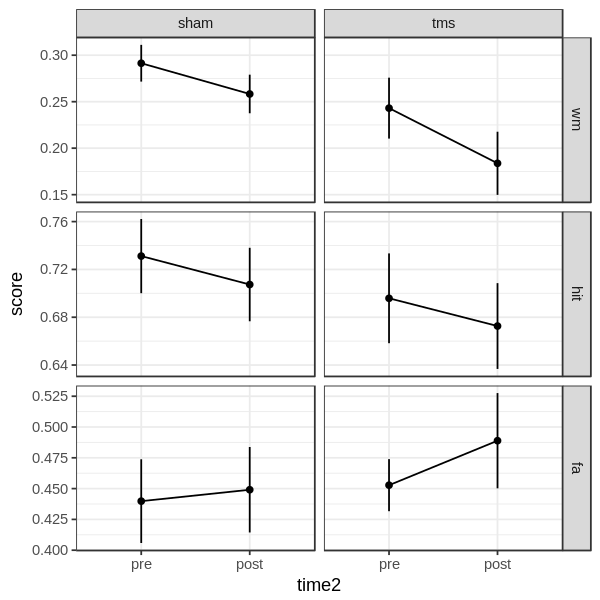

In [373]:
#df.remove <- subset(pre.post.melt, !subj.id %in% c("nat","sar")) 

df <- summarySE(pre.post.melt, "score", c("subj.id","group","time"))
df <- summarySE(df, "score", c("time","group"))

# Here I split the string based on ".", eg post.wm becomes "post" and "wm".
df$time2 <- apply(matrix(df$time), 1, function(xx) strsplit(xx, split="\\.")[[1]][1])
df$time2 <- as.factor(df$time2)
df$param <- apply(matrix(df$time), 1, function(xx) strsplit(xx, split="\\.")[[1]][2])
df$param <- as.factor(df$param)

# Try to reorder the factors (time2, and param) so that the plot looks the same as previous one...
df$time2 <- factor(df$time2, levels = c("pre","post"))    
df$param <- factor(df$param, levels = c("wm","hit","fa"))    
    
options(repr.plot.width=5, repr.plot.height=5)    
ggplot( df, aes(x=time2, y=score,
                ymax=score+se, 
                ymin=score-se, group = group) ) + 
  geom_point() + geom_line() +
  geom_errorbar(width=0) +
  facet_grid(param~group,scales="free_y") +
  theme_bw()


### Normalizing the WM scores
For each subject, I normalized the scores (Hit - FA) by dividing both PRE and POST with PRE scores. This makes the PRE (baseline) scores to start always at value 1.0. Note: I normalized not the hits and false alarms separately, but the overall Hit - FA.

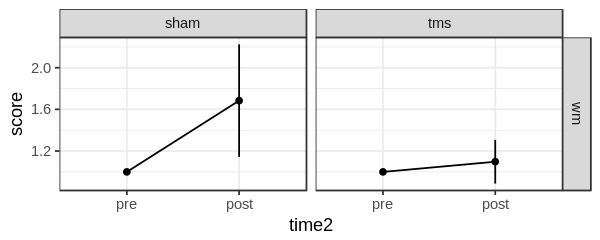

In [310]:
# (3) Dividing PRE and POST scores by PRE.
norm.pre.post <- ddply(hit.fa, c("subj.id","lag","group"), function(xx){
                    pre  <- subset(xx, block <=3 )
                    post <- subset(xx, block > 3 )
                    pre.wm  <- mean(pre$hit.min.fa, na.rm=TRUE)
                    post.wm <- mean(post$hit.min.fa, na.rm=TRUE)
                    pre.hit <- mean(pre$prop.yes, na.rm=TRUE)
                    post.hit<- mean(post$prop.yes, na.rm=TRUE)
                    pre.fa  <- mean(pre$false.alarm, na.rm=TRUE)
                    post.fa <- mean(post$false.alarm, na.rm=TRUE) 
                    return(data.frame( "pre.wm"  = pre.wm/pre.wm,
                                       "post.wm" = post.wm/pre.wm,
                                       "pre.hit" = pre.hit/pre.hit,
                                       "post.hit"= post.hit/pre.hit,
                                       "pre.fa"  = pre.fa/pre.fa,
                                       "post.fa" = post.fa/pre.fa))
} )


##### Let's melt the data frame
norm.pre.post.melt <- melt(norm.pre.post, id.vars = c("subj.id","lag","group"), 
                           measure.vars = c("pre.wm","post.wm","pre.hit","post.hit","pre.fa","post.fa"))

colnames(norm.pre.post.melt)[4] = "time"
colnames(norm.pre.post.melt)[5] = "score"

df <- summarySE(norm.pre.post.melt, "score", c("subj.id","group","time"))
df <- summarySE(df, "score", c("time","group"))
df <- subset(df, time %in% c("pre.wm","post.wm"))

# Here I split the string based on ".", eg post.wm becomes "post" and "wm".
df$time2 <- apply(matrix(df$time), 1, function(xx) strsplit(xx, split="\\.")[[1]][1])
df$time2 <- as.factor(df$time2)
df$param <- apply(matrix(df$time), 1, function(xx) strsplit(xx, split="\\.")[[1]][2])
df$param <- as.factor(df$param)

# Try to reorder the factors (time2, and param) so that the plot looks the same as previous one...
df$time2 <- factor(df$time2, levels = c("pre","post"))    
df$param <- factor(df$param, levels = "wm")#c("wm","hit","fa"))    

# Show the normalized data in a plot
options(repr.plot.width=5, repr.plot.height=2)
ggplot( df, aes(x=time2, y=score,
                ymax=score+se, 
                ymin=score-se, group = group) ) + 
  geom_point() + geom_line() +
  geom_errorbar(width=0) + #ylim(0.7,1.5) +
  facet_grid(param~group,scales="free_y") +
  theme_bw()


## Perform ANOVA 
#ezANOVA( data=norm.pre.post.melt,
#         dv=score,
#        wid=subj.id,
#         within=time,
#         between=group )


### What if, instead of doing an ANOVA, I do one-tailed t-test?
For each subject, I computed the difference between POST minus PRE in both groups. Then, the mean of this difference between the treatment and sham groups will be compared.


[1] "Difference in WM scores (one-tailed), Sham vs TMS group, p = 0.064584"

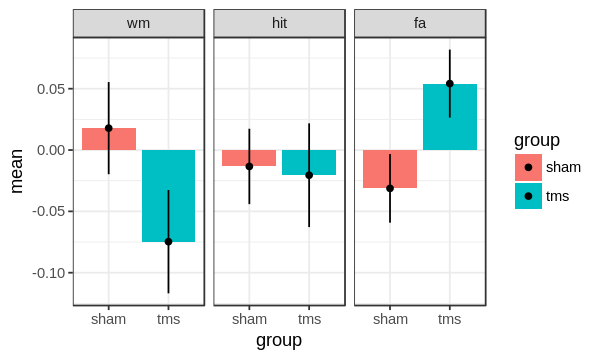

In [311]:
#(4) What about finding the difference?
pre.post$wm <- pre.post$post.wm-pre.post$pre.wm
pre.post$wm.norm <- pre.post$wm/pre.post$pre.wm

pre.post$hit <- pre.post$post.hit-pre.post$pre.hit
pre.post$hit.norm <- pre.post$hit/pre.post$pre.hit

pre.post$fa <- pre.post$post.fa-pre.post$pre.fa
pre.post$fa.norm <- pre.post$fa/pre.post$pre.fa

pre.post.diff <- pre.post[,-which(names(pre.post) %in% c( "pre.wm","post.wm",
                                                          "pre.hit","post.hit",
                                                          "pre.fa","post.fa"))]

diff.score <- melt(pre.post.diff, id.vars = c("subj.id","lag","group"),
                   measure.vars = c("wm.norm","wm",
                                    "hit.norm","hit",
                                    "fa.norm","fa"))
colnames(diff.score)[4] = "variable"
colnames(diff.score)[5] = "score"


grp.diff <- ddply(diff.score, c("group","variable"), 
                        function(xx){
                          mean = mean(xx$score)
                          stde = sd(xx$score)/sqrt(length(xx$score))
                          return(data.frame("n"=nrow(xx),"score"=mean,"se"=stde))
                        })

# Plot the graph for each score. Position dodge is to make the bars side-by-side.
# Note: What is width argument in position_dodge()?
options(repr.plot.width=5, repr.plot.height=3)

ggplot(  subset(grp.diff, grp.diff$variable %in% c( "wm","hit","fa")), 
        aes(x=group,y=mean,ymax=mean+se,ymin=mean-se,fill=group )) + 
  geom_bar(stat="identity", position=position_dodge(width=0.9))  +
  geom_point(aes(y=score), position=position_dodge(width=0.9)) +
  geom_errorbar(stat="identity", width=0,position=position_dodge(width=0.9)) +
  facet_grid(.~variable,scales="free_y") +
  #ylim(-0.1,0.05)+
  theme_bw()

diff.score.avg <- ddply(diff.score, c("subj.id","group","variable"), 
                                 function(xx){
                                   mean = mean(xx$score)
                                   stde = sd(xx$score)/sqrt(length(xx$score))
                                   return(data.frame("n"=nrow(xx),"mean"=mean,"se"=stde))
                                 }) 
diff.score.avg <- subset(diff.score.avg, diff.score.avg$variable=="wm")

t <- t.test(subset(diff.score.avg, diff.score.avg$group=="tms")$mean, 
       subset(diff.score.avg, diff.score.avg$group=="sham")$mean,
       alternative = c("less"))
sprintf("Difference in WM scores (one-tailed), Sham vs TMS group, p = %f",t$p.value)



### Reaction time to respond
I also recorded RT in each trial. Noe that reaction time covers the time for the subject to respond plus the time for the experimenter to press the keyboard (and record down the answer). Note: The <b>NA</b> means no-lag test, that is, a false alarm test.

In [274]:
if(0){
options(repr.plot.width=5, repr.plot.height=5)

# Get the numerical values of the RT data....
allsubjects$RT2 <- apply(matrix(allsubjects$RT), 1, 
                         function(xx) as.numeric(strsplit(xx, split="\\:")[[1]][2]))
#str(allsubjects)

react.time <- ddply(allsubjects, c("subj.id","lag", "group"), function(xx){
                  pre  <- subset(xx, block <=3 )
                  post <- subset(xx, block > 3 )
                  return(data.frame( "pre"  = mean(pre$RT2, na.rm=TRUE),
                                     "post" = mean(post$RT2, na.rm=TRUE) ))
} )

react.time.melt <- melt(react.time, id.vars = c("subj.id","lag","group"), 
                           measure.vars = c("pre","post"))
colnames(react.time.melt)[4] <- "time"

temp <- summarySE(react.time.melt, "value", c("time","lag","group"))

# Plot the graph for each score......
options(repr.plot.width=5, repr.plot.height=3)
ggplot( temp, aes(x=time, y=value,
                  ymax=value+se, 
                  ymin=value-se,
                  group=lag,
                  col=lag) ) + 
  geom_point() + geom_line() +
  geom_errorbar(width=0) +
  facet_grid(.~group,scales="free_y") + #ylab("Mean scores")+
  theme_bw()
}

### Is the task really that hard?!
Supposed we assume that the presence of 3 anchors distracts the subjects. What if we remove trials in which the distance between the earliest anchor and the probe = 10 degrees.

## Kinematic Analyses
This section analyzes performance during motor learning. A few behavioral measures were considered to estimate learning:
1. Learning slope, 
2. Mean absolute deviation after training (POST), 
3. Total reinforcement between the two groups.

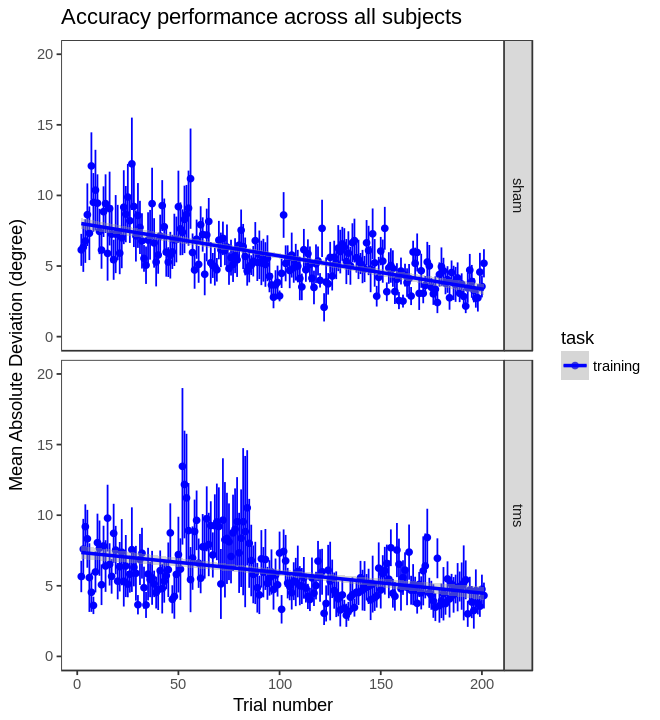

In [376]:
#library(corrplot)
options(repr.plot.width=5.5, repr.plot.height=6)

dirpath <- "~/Documents/R/TMS/"   # home directory in linux is shown as ~
setwd(dirpath)

## Easier to select which test version to use. This also determines filename to save.
myTest_version_string = "tms_param"   
source(paste(myTest_version_string,".R",sep=""))

allsubjects <- NULL
############################## Open textfile containing raw data!!!
allsubjects <- read.csv("all_kin.csv", header=TRUE)
#allsubjects <- subset(allsubjects, !subj.id %in% c("tub","anj"))



# (1) Group average for the individual trial....
# Exclude the pre-train block...
my.df <- ddply( subset(allsubjects, task=="training" & block %in% c(1,2,3,4)), "subj.id", function(xx){
                      xx$newTrial = 1:nrow(xx)
                      xx$angle_maxv_shift = abs(xx$angle_maxv_shift)
                      return(xx) }
)

error.grp <- summarySE( my.df, "abs.PD", c("newTrial","task","group"), na.rm = TRUE)
error.grp <- subset(error.grp, error.grp$newTrial > 1)

g<-ggplot(error.grp, aes( x=newTrial,y=abs.PD,
                       ymin=abs.PD-se,
                       ymax=abs.PD+se,
                       color=task) ) +
  scale_color_manual(values=c("training"="blue","motor_post"="red")) +
  scale_fill_manual (values=c("training"="blue","motor_post"="red")) +
  geom_point() + geom_errorbar(width=0) +
  geom_smooth(method="lm") +
  #geom_ribbon( aes(fill=task), alpha=0.4 ) +
  ylim(0,20) + 
  ggtitle("Accuracy performance across all subjects") +
  xlab("Trial number") + ylab("Mean Absolute Deviation (degree)") +
  facet_grid(group~.) +
  theme_bw() + theme( 
    panel.background = element_rect(fill = "transparent") # bg of the panel
    , plot.background = element_rect(fill = "transparent") # bg of the plot
    , panel.grid.major = element_blank() # get rid of major grid
    , panel.grid.minor = element_blank() # get rid of minor grid
  )
g
#ggsave( sprintf('David-grant.pdf'),g)


In [378]:
### Get learning slope? Using ddply with a predefined function.
get.learn.slope <- function(xx) {
  train.blocks <- subset(xx, task=="training" & block %in% c(1,2,3,4))
  tot_trial    <- seq(1, length(train.blocks$angle_maxv_shift))
  yy <- lm(abs(train.blocks$angle_maxv_shift) ~ tot_trial)
  yy <- yy$coefficients[2]
  return (yy)
}

lin.slope <- ddply(allsubjects, c("subj.id","group"), get.learn.slope)

t <- t.test(subset(lin.slope,group=="sham" )$tot_trial,
       subset(lin.slope,group=="tms")$tot_trial,
       alternative = c("less"))

sprintf("Difference in slope, p = %f",t$p.value)



# (2) Average accuracy motor post
post.grp <- subset(allsubjects, task=="motor_post")
#post.grp <- summarySE( post.grp, "abs.PD", c("task","group"), na.rm = TRUE)
t <- t.test(subset(post.grp,group=="tms" )$abs.PD,
       subset(post.grp,group=="sham")$abs.PD)

sprintf("Difference in Accuracy during Motor Post, p = %f",t$p.value)



# (3) Total reinforcement.....
reward <- summarySE(my.df, "boom", c("subj.id","group"))
#reward <- summarySE(reward, "boom", c("group"))
t <- t.test(subset(reward,group=="tms" )$boom,
       subset(reward,group=="sham")$boom)

sprintf("Difference in total reward, p = %f",t$p.value)

[1] "Difference in slope, p = 0.222557"

[1] "Difference in Accuracy during Motor Post, p = 0.006486"

[1] "Difference in total reward, p = 0.533967"

### Difference in total reward between block 1 and 4.
By taking the difference in terms of proportion (or percent) reward between training block 1 and 4, we can see how TMS group does not show much improvement or increment, but the sham group does.


[1] "Reward increment between Sham vs TMS group, p = 0.066357"

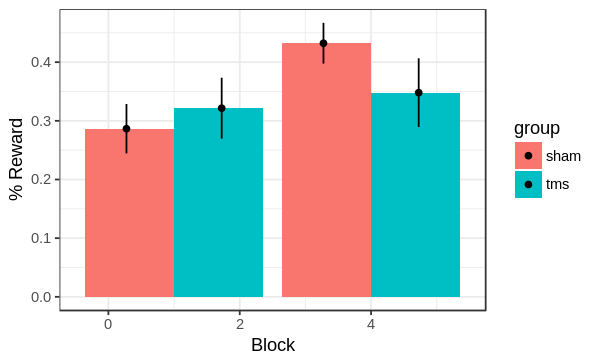

In [381]:
# (4) Total reinforcement for different blocks.....
reward.blk <- summarySE(my.df, "boom", c("subj.id","group","block"))
reward.blk.avg <- summarySE(reward.blk, "boom", c("group","block"))
#reward.blk.avg <- subset(reward.blk.avg, reward.blk.avg$block<3)
#reward.blk.avg
# Then draw the plot to compare two groups...
options(repr.plot.width=5, repr.plot.height=3)

g<-ggplot(subset(reward.blk.avg, block%in%c(1,4)),
       aes(x=block,y=boom,ymin=boom-se,ymax=boom+se,fill=group) ) +
  geom_bar(stat="identity", position=position_dodge())  +
  geom_point(aes(y=boom), position=position_dodge(width=2.9)) +
  geom_errorbar(stat="identity",width=0,position=position_dodge(width=2.9)) +
  xlab("Block") + ylab("% Reward") +
  theme_bw()
g
#ggsave("plot.pdf",g)


### What if we compute the difference between block 1 and block 4.
reward.diff <- ddply(reward.blk, c("subj.id","group"), function(xx){
                  early = subset(xx, block==1)
                  late  = subset(xx, block==4)
                  c("diff"=late$boom - early$boom) }
                  )

t <- t.test(subset(reward.diff,group=="tms" )$diff,
       subset(reward.diff,group=="sham")$diff,
       alternative = c("less"))
#t
sprintf("Reward increment between Sham vs TMS group, p = %f",t$p.value)


In [ ]:
#### Change in movement direction contingent upon current trial outcome.....
#Trial-to-trial change in movement direction was also compared between the TMS and sham group. The plot below includes 4 training blocks and motor post without reinforcement (so it is shown as "failure").

# (5) Average delta.m
d.m <- ddply( allsubjects,  c('subj.id','task',"group"),
              function(xx) {
                xx <- xx[ order(xx$newTrial), ]  # ensuring the order
                abs.dm<-NULL; delta.m<-NULL; next.boom<-NULL
                for (i in 1:(nrow(xx)-1)) {
                  # Accessing each trial; keep adding element to variable "delta.m"
                  delta.m  <- c(delta.m,    xx[i+1,"angle_maxv_shift"]-xx[i,"angle_maxv_shift"])
                  abs.dm   <- c(abs.dm, abs(xx[i+1,"angle_maxv_shift"]-xx[i,"angle_maxv_shift"]))
                  next.boom<- c(next.boom, xx[i+1,"boom"])
                }
                delta.m  <- c(delta.m, NA); abs.dm <- c(abs.dm, NA)
                return(data.frame(trial=xx$newTrial,
                                  block=xx$block,
                                  session=unique(xx$session),
                                  delta.m=delta.m,
                                  abs.dm = abs.dm,
                                  next.boom = c(next.boom,0),
                                  success=xx$success )) 
              }
)
avg.trial.trial <- ddply( d.m, c("task","success","group","block"), 
                          function(xx){
                            n.subj = length(unique(d.m$subj.id))
                            c( avg = mean(xx$abs.dm, na.rm = TRUE),
                               N  = length(xx$abs.dm),
                               n.subj  = n.subj,
                               se = sd(xx$abs.dm, na.rm = TRUE)/sqrt(n.subj)) # Note!
                          })

# Create clearer naming to indicate reward status for the training phase.
avg.trial.trial$task.block = ifelse (avg.trial.trial$task=="training",
                                      sprintf("%s_%s", avg.trial.trial$task, avg.trial.trial$block), 
                                      as.character(avg.trial.trial$task))
avg.trial.trial$task.block <- as.factor(avg.trial.trial$task.block)

# Reorder the levels according to the following task phase....
task = c("pre_train", "training_1","training_2","training_3","training_4","motor_post")
avg.trial.trial$task.block <- factor(avg.trial.trial$task.block, levels = task)

avg.trial.trial <- subset(avg.trial.trial, avg.trial.trial$task!="pre_train")

options(repr.plot.width=7, repr.plot.height=3)
ggplot(avg.trial.trial, aes(x=task.block, 
                            y=avg, 
                            ymin=avg-se,
                            ymax=avg+se,
                            group=success,
                            color=success)) + 
  geom_point() + geom_line() +
  geom_errorbar(width=0) + 
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle("Average magnitude of change in movement direction") +
  ylab("Angle (degree)") + xlab("") +
  facet_grid(.~group) +
  theme_bw() + theme( 
    panel.background = element_rect(fill = "transparent") # bg of the panel
    , plot.background = element_rect(fill = "transparent") # bg of the plot
    , panel.grid.major = element_blank() # get rid of major grid
    , panel.grid.minor = element_blank() # get rid of minor grid
    
  )
